http://koaning.io/posts/outliers-selection-vs-detection/

Article -> [Precision vs Recall](https://towardsdatascience.com/precision-vs-recall-386cf9f89488)

## Dataset
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
csv_path = "/Users/robin/Kaggle/creditcard.csv"

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV

df = pd.read_csv(csv_path).rename(str.lower, axis=1)
X, y = df.drop(columns=["class", "time", "amount"]), df['class']

In [3]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This is an extremely unballeenced dataset

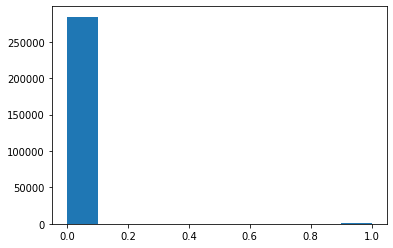

In [9]:
plt.hist(y);

How about we try to find outliers that simply correlate with fraudulent cases? It might be surprise to find out that scikit learn has support for this but it occurs via a slightly unusual pattern. With the dataset loaded I’ll run an [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html). Note that I am not labelling, I am merely looking for outliers.

In [4]:
from sklearn.ensemble import IsolationForest
forest = IsolationForest(contamination=0.1, behaviour="new").fit(X)

Run the model on the train data

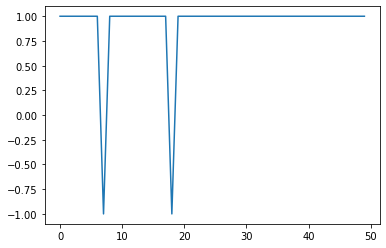

In [13]:
plt.plot(forest.predict(X[:50]))

We can look at the algorithm results but we’re mostly interested in finding a good value for the `contamination` parameter. One thing you could do manually is to calculate, say, the precision of the predictions.

In [14]:
converted = np.where(forest.predict(X) == 1, 0, 1)
precision_score(y, converted)

0.015413784628348724

Note that we’re using `np.where` here because an outlier detector in scikit learn will output either -1 or +1 while the fraud label will be 0 or 1.

## The Problem
We could now go and write a for-loop to consider all the values for `contamination` but this is a lazy hack. It is much more preferable to cross validate the hyperparamter in a gridsearch. You might be wondering how to write a gridsearch that might facilitate this though. After all, we need to manually convert the models output to something the precision score can use and we need to figure out a way to allow our y and X values to also be cross validated. Also, generally, scikit learn has a pattern of using `sklearn.metrics.make_scorer` that accepts functions of signature `score(y_true, y_pred)`. So how on earth are we going to get this to work?

The main trick is to recognise two things:

* Scikit Learn will also accept a metric function with the signature `score(model, X, y)` and if you write a function this way you don’t need make_scorer.
* Scikit Learn models that have a signature of `.fix(X)` can also accept `.fit(X, y)`. In this case the y value is ignored by the model but can be used for any other part of the pipeline. This includes metrics.

These two facts combined give us a nice pattern using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

In [16]:
df_subset = df.sort_values('class', ascending=False)[:80000]
X_subset = df_subset.drop(columns=['amount', 'class', 'time']).values
y_subset = df_subset['class']

def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == 1, 0, 1))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == 1, 0, 1))

forest = IsolationForest(contamination=0.1, behaviour="new", max_features=0.2)

mod = GridSearchCV(estimator=forest, 
                   cv=5,
                   n_jobs=-1,
                   scoring={"precision": outlier_precision,
                            "recall": outlier_recall}, 
                   refit="precision",
                   param_grid={'contamination': np.linspace(0.0001, 0.02, 30)})

mod.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=IsolationForest(behaviour='new', bootstrap=False,
                                       contamination=0.1, max_features=0.2,
                                       max_samples='auto', n_estimators=100,
                                       n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'contamination': array([0.0001    , 0.00078621, 0.00147241, 0.00215862, 0.00284483,
       0.0035...
       0.00696207, 0.00764828, 0.00833448, 0.00902069, 0.0097069 ,
       0.0103931 , 0.01107931, 0.01176552, 0.01245172, 0.01313793,
       0.01382414, 0.01451034, 0.01519655, 0.01588276, 0.01656897,
       0.01725517, 0.01794138, 0.01862759, 0.01931379, 0.02      ])},
             pre_dispatch='2*n_jobs', refit='precision',
             return_train_score=False,
             scoring={'precision': <function outlier_

In [17]:
type(mod)

sklearn.model_selection._search.GridSearchCV

In [20]:
list(mod.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_contamination',
 'params',
 'split0_test_precision',
 'split1_test_precision',
 'split2_test_precision',
 'split3_test_precision',
 'split4_test_precision',
 'mean_test_precision',
 'std_test_precision',
 'rank_test_precision',
 'split0_test_recall',
 'split1_test_recall',
 'split2_test_recall',
 'split3_test_recall',
 'split4_test_recall',
 'mean_test_recall',
 'std_test_recall',
 'rank_test_recall']

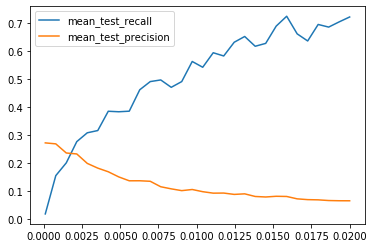

In [34]:
plt.plot(mod.cv_results_['param_contamination'].data, mod.cv_results_['mean_test_recall'], label='mean_test_recall')
plt.plot(mod.cv_results_['param_contamination'].data, mod.cv_results_['mean_test_precision'], label='mean_test_precision')
plt.legend()